# CLASSIFICAÇÃO DE IMAGENS DE SATÉLITE - PYTORCH

## Descrição

Dataset para Classificação de Imagens de Satélite RSI-CB256. Esse dataset tem 4 classes distintas obtidas por sensores e imagens do Google Maps. [Link para o Dataset no Kaggle](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)

## Importações

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_palette('dark')
import time
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt 
from torchsummary import summary
from pytorchtools import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

In [11]:
# Definindo o SEED
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Funções

In [12]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [17]:
def saving_best_model(total_val_loss):   
    if best_val_loss > total_val_loss:
            best_val_loss = total_val_loss
            best_epoch = e+1
            print(f'Melhor época: {e+1}')
            torch.save(model.state_dict(), '../models/best_model.pth')
            print("Melhor modelo salvo\n")
    else:
        pass
    return best_val_loss, best_epoch

In [18]:
def training(model, LR = 1e-03, EPOCHS = 200):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print("[INFO] Inicializando o modelo ConvNet...\n")
    
    opt = Adam(model.parameters(), lr=LR)

    H = {"train_loss": [],
         "train_acc": [],
         "val_loss": [],
         "val_acc": []}
    
    print("[INFO] Iniciando o treinamento...\n")
    
    best_val_loss = 100
    
    start_time = time.time()
    
    for e in range(0, EPOCHS):
        
        start_time_epoch = time.time()
        # Treino
        model.train()
        
        total_train_loss = 0
        total_val_loss = 0 
        train_correct = 0
        val_correct = 0
        
        for (x, y) in train_dl:
            
            (x, y) = (x.to(device), y.to(device))
            
            pred = model(x)
            loss = lossFn(pred, y)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            total_train_loss += loss
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Validação
        with torch.no_grad():
            
            model.eval()
            
            for (x, y) in val_dl:
            
                (x, y) = (x.to(device), y.to(device))

                pred = model(x)
                total_val_loss += lossFn(pred, y)

                val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        avg_train_loss = total_train_loss/train_steps
        avg_val_loss = total_val_loss/val_steps
        
        train_correct = train_correct / len_train
        val_correct = val_correct / len_val
        
        H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
        H["train_acc"].append(train_correct)
        H["val_loss"].append(avg_val_loss.cpu().detach().numpy())
        H["val_acc"].append(val_correct)

        end_time_epoch = time.time()
        epoch_time = end_time_epoch - start_time_epoch

        print("[INFO] ÉPOCA: {}/{}".format(e + 1, EPOCHS))
        print("loss: {:.6f} - accuracy: {:.4f} - val_loss: {:.6f} - val_accuracy: {:.4f}".format(avg_train_loss, train_correct, avg_val_loss, val_correct))         
        print(f'Tempo de treino nessa época: {epoch_time:.3f}s')
            
        early_stopping(avg_val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping\n")
            break
            
        if best_val_loss > total_val_loss:
                best_val_loss = total_val_loss
                best_epoch = e+1
                print(f'Melhor época: {e+1}')
                torch.save(model.state_dict(), 'best_model.pth')
                print("Melhor modelo salvo\n")
        else:
            continue
        
        best_val_loss = best_val_loss
        
    end_time = time.time()
    
    print("[INFO] Tempo total de treinamento: {:.2f}s".format(end_time - start_time))
    
    return H

In [20]:
def plot_acc_loss(history):

    acc = history['train_acc']
    val_acc = history['val_acc']

    loss = history['train_loss']
    val_loss = history['val_loss']

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.show()

In [23]:
def class_report(model, load=False):
    if load == True:
        model.load_state_dict(torch.load('../models/best_model.pth'))
        
    model.eval()
    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for test_data in test_dl:
            test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
            pred = model(test_images).argmax(dim=1)
            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())  
    
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    _, ax = plt.subplots(figsize=(6,6))
    
    ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"},
                     cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)  
    ax.set_ylabel('Prediction', fontsize=12);
    ax.set_xlabel('Ground Truth', fontsize=12)

In [78]:
def class_img(path):
    image = Image.open(path).convert('RGB')
    plt.imshow(image)
    transform = tt.Compose([tt.ToTensor(), 
                            tt.Resize(256),
                            tt.CenterCrop(224)])
    img_tensor = transform(image)
    img_cuda = img_tensor.cuda()
    img_tt = img_cuda.unsqueeze(0) 
    
    classification = class_names[model(img_tt).argmax(dim=1)[0]]
    prob = (torch.exp(model(img_tt))*100).max().item()
    
    print(f'Classificação: {classification} - {prob}% de probabilidade')

## Pré-processamento dos dados

In [4]:
# Selecionar o device baseado na disponibilidade do "cuda"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Definindo o diretório das imagens
path = '../data/satellite_splited/train'
origin_dir = pathlib.Path(path)

In [6]:
# Nome de cada classe
class_names = [item.name for item in origin_dir.glob("*")]
class_names

['cloudy', 'desert', 'green_area', 'water']

In [7]:
# Definindo o path de cada split
train_path = '../data/satellite_splited/train'
val_path = '../data/satellite_splited/val/'
test_path = '../data/satellite_splited/test/'

In [8]:
# Criando o objeto de transformação
transform = tt.Compose([tt.Resize(224),
                        tt.ToTensor()])

In [13]:
# Definindo parâmetros
BATCH_SIZE = 32 

# Carregando e transformando as imagens

# Treino
train_data = ImageFolder(train_path, transform=transform)
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)

# Validação
val_data = ImageFolder(val_path, transform=transform)
val_dl = DataLoader(val_data, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, generator=g)

# Teste
test_data = ImageFolder(test_path, transform=transform)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, worker_init_fn=seed_worker, generator=g)

In [10]:
# Calculando os passos por época no treino e na validação

len_train = len(train_dl.dataset)
len_val = len(val_dl.dataset)

train_steps = len(train_dl.dataset) // BATCH_SIZE
val_steps = len(val_dl.dataset) // BATCH_SIZE

In [11]:
# Obtendo o shape do tensor
for inputs, labels in test_dl:
    inputs, labels = inputs.cpu(), labels.cpu()
    print(inputs.shape)
    break

torch.Size([32, 3, 224, 224])


## Modelagem

In [12]:
# Classe que contém o Módulo do modelo
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=(1,1))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3,3), padding=(1,1))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(3,3), padding=(1,1))
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.fc1 = nn.Linear(in_features=200704, out_features=128)
        self.relu4 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=128, out_features=4)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu4(x)
        
        x = self.fc2(x)
        output = self.softmax(x)
        
        return output

In [14]:
print(model)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [13]:
# Sumário do modelo
model = ConvNet()

if torch.cuda.is_available():
    model.cuda()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]           9,280
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         147,712
              ReLU-8          [-1, 256, 56, 56]               0
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Linear-10                  [-1, 128]      25,690,240
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 4]             516
       LogSoftmax-13                    [-1, 4]               0
Total params: 25,848,196
Trainable para

In [15]:
# Testando o shape de saída do modelo
for images, labels in train_dl:
    images, labels = images.cuda(), labels.cuda()
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 3, 224, 224])
torch.Size([32, 4])


In [16]:
# Parâmetros
lossFn = nn.NLLLoss()
early_stopping = EarlyStopping(patience=50, verbose=False)

In [19]:
# Treinamento da rede neural
history1 = training(model, EPOCHS=100)

[INFO] Inicializando o modelo ConvNet...

[INFO] Iniciando o treinamento...

[INFO] ÉPOCA: 1/100
loss: 0.544549 - accuracy: 0.7427 - val_loss: 0.640009 - val_accuracy: 0.7460
Tempo de treino nessa época: 113.276s
Melhor época: 1
Melhor modelo salvo

[INFO] ÉPOCA: 2/100
loss: 0.316066 - accuracy: 0.8754 - val_loss: 0.226540 - val_accuracy: 0.9085
Tempo de treino nessa época: 106.949s
Melhor época: 2
Melhor modelo salvo

[INFO] ÉPOCA: 3/100
loss: 0.283706 - accuracy: 0.8853 - val_loss: 0.324868 - val_accuracy: 0.8579
Tempo de treino nessa época: 107.638s
EarlyStopping counter: 1 out of 50
[INFO] ÉPOCA: 4/100
loss: 0.287394 - accuracy: 0.8858 - val_loss: 0.271901 - val_accuracy: 0.9059
Tempo de treino nessa época: 106.943s
EarlyStopping counter: 2 out of 50
[INFO] ÉPOCA: 5/100
loss: 0.250981 - accuracy: 0.8988 - val_loss: 0.242099 - val_accuracy: 0.9130
Tempo de treino nessa época: 107.096s
EarlyStopping counter: 3 out of 50
[INFO] ÉPOCA: 6/100
loss: 0.254749 - accuracy: 0.8977 - val_loss

[INFO] ÉPOCA: 49/100
loss: 0.077174 - accuracy: 0.9761 - val_loss: 0.270088 - val_accuracy: 0.9449
Tempo de treino nessa época: 107.534s
EarlyStopping counter: 11 out of 50
[INFO] ÉPOCA: 50/100
loss: 0.084125 - accuracy: 0.9741 - val_loss: 0.112073 - val_accuracy: 0.9716
Tempo de treino nessa época: 107.290s
EarlyStopping counter: 12 out of 50
[INFO] ÉPOCA: 51/100
loss: 0.096859 - accuracy: 0.9696 - val_loss: 0.148141 - val_accuracy: 0.9538
Tempo de treino nessa época: 107.573s
EarlyStopping counter: 13 out of 50
[INFO] ÉPOCA: 52/100
loss: 0.052410 - accuracy: 0.9845 - val_loss: 0.109905 - val_accuracy: 0.9751
Tempo de treino nessa época: 107.566s
EarlyStopping counter: 14 out of 50
[INFO] ÉPOCA: 53/100
loss: 0.043107 - accuracy: 0.9896 - val_loss: 0.365522 - val_accuracy: 0.9156
Tempo de treino nessa época: 107.518s
EarlyStopping counter: 15 out of 50
[INFO] ÉPOCA: 54/100
loss: 0.063116 - accuracy: 0.9807 - val_loss: 0.111294 - val_accuracy: 0.9725
Tempo de treino nessa época: 107.687

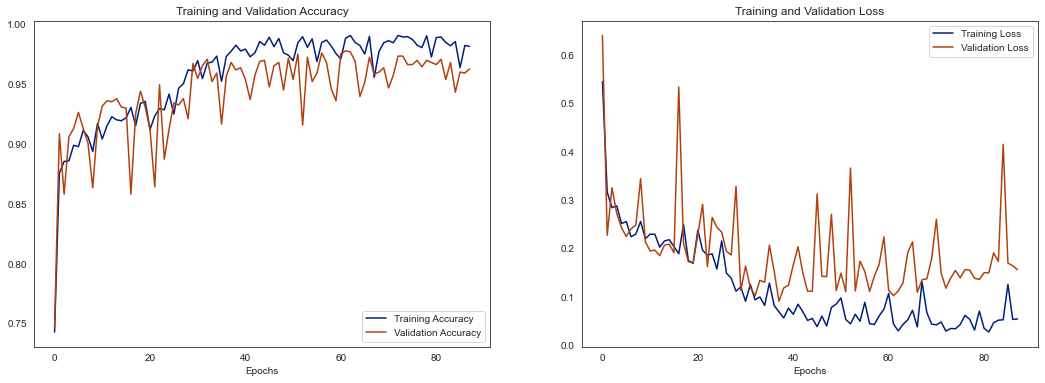

In [21]:
# Acurácia e perda de treino e validação
plot_acc_loss(history1)

              precision    recall  f1-score   support

      cloudy     0.9929    0.9267    0.9586       150
      desert     0.9048    1.0000    0.9500       114
  green_area     1.0000    0.9867    0.9933       150
       water     0.9867    0.9867    0.9867       150

    accuracy                         0.9734       564
   macro avg     0.9711    0.9750    0.9721       564
weighted avg     0.9753    0.9734    0.9736       564



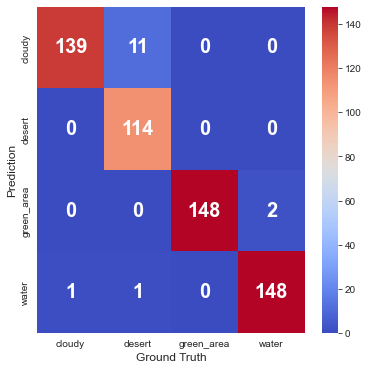

In [25]:
# Desempenho do modelo no dataset de teste
class_report(model, load=True)

Classificação: water - 100.0% de probabilidade


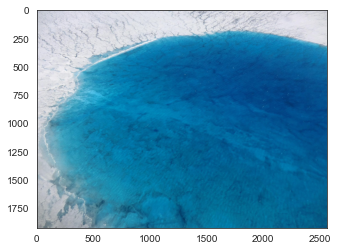

In [79]:
# Testando a classificação da primeira imagem
class_img('../data/test/test1.jpg')

Classificação: desert - 100.0% de probabilidade


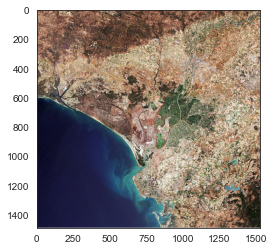

In [80]:
# Testando a classificação da segunda imagem
class_img('../data/test/test2.jpeg')

## Conclusão

- A rede neural foi treinada usando "CUDA", o que acelerou profundamente o treinamento, ainda mais considerando a complexidade do modelo;
- O modelo performou muito bem em todas as classes, com maior dificuldade em diferenciar entre "cloudy" e "desert", com 11 imagens sendo erroneamente classificadas como "desert";
- O modelo obteve 97,34% de acurácia no dataset de teste, onde obteve 95% de acurácia para "desert" (pior desempenho) e 99,33% de acurácia para "green_area" (melhor desempenho).

Se quiser tirar alguma dúvida, fazer alguma sugestão ou conversar sobre o projeto, entre em contato comigo pelo meu [LinkedIn](https://www.linkedin.com/in/luanrdutra/). Também aproveite e veja o que eu tenho feito no meu [GitHub](https://github.com/LuanRD).

Obrigado pela atenção :D 